# Clinical workflow integration

The imaging data provided for training the model was transformed from DICOM format into .png to help aid in the image pre-processing and model training steps of this project. In the real world, however, the pixel-level imaging data are contained inside of standard DICOM files. 

This notebook creates a DICOM wrapper that takes in a standard DICOM file and outputs data in the format accepted by the model:
* Proper image acquisition type (i.e. X-ray)
* Proper image acquisition orientation (i.e. those present in your training data)
* Proper body part in acquisition

In [1]:
import keras 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom

from PIL import Image
from typing import Optional, Tuple

from gradcam import grad_cam

%matplotlib inline

Using TensorFlow backend.


In [12]:
def read_dicom(filename:str) -> Optional[np.array]:
    '''Reads in a .dcm file and returns an array with the image data
    
    The model returns None if the DICOM file is not appropriate for the
    classifier. In particular, it checks for:
        - Digital radiographies
        - Chest parts
        - Body position 
    
    See: https://www.dicomlibrary.com/dicom/ for code references
    '''
    ds = pydicom.dcmread(filename)
    
    if ds.Modality != 'DX':
        print('Modality not supported:', ds.Modality)
        print('This device only works with the DX modality (Digital Radiography)')
        return None
    
    if ds.BodyPartExamined != 'CHEST':
        print('Body part not supported:', ds.BodyPartExamined)
        print('This device only works with Chest Radiographies')
        return None
    
    if ds.PatientPosition not in ['AP', 'PA']:
        print('Body position not supported:', ds.PatientPosition)
        print('This device only works with AP or PA positions')
        return None
    
    print(f'Patient age: {ds.PatientAge}, sex: {ds.PatientSex}')
    print('Study description:', ds.StudyDescription)
    return ds.pixel_array
    
    
def preprocess_image(img_array : np.array, img_size : Tuple[int]):
    '''Pre-process the image to the format expected by the classifier'''
    batch, height, width, channels = img_size
    img = Image.fromarray(img_array)
    img = img.resize((height, width))
    img = np.array(img)
    img = img / 255.
    
    if len(img.shape) == 2:
        img = np.dstack((img, img, img))
    img = np.expand_dims(img, axis=0)
    return img


def load_model(model_path, weight_path):
    '''Loads in a model with weights and compiles it'''
    with open(model_path) as model_json:
        model = keras.models.model_from_json(model_json.read())
    model.load_weights(weight_path)
    return model


def predict_image(model, img, thresh): 
    '''Predict the presence of pneumonia in the image'''
    prob = model.predict(img)[0][0]
    print('Probability of Pneumonia:', prob)
    prediction = prob > thresh
    print('Predicted Pneumonia:', prediction)
    print()
    
    last_conv_layer_name = "block5_conv3"

    # Generate class activation heatmap
    heatmap = grad_cam(img, model, last_conv_layer_name)
    plt.imshow(img[0], cmap='gray')
    plt.imshow(heatmap, cmap='magma', alpha=0.5)
    plt.axis('off')
    plt.show()
    return prediction

Patient age: 81, sex: M
Study description: No Finding
Probability of Pneumonia: 0.6751319
Predicted Pneumonia: True



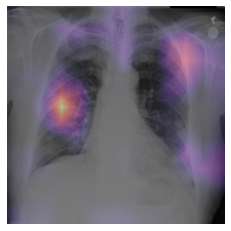

Patient age: 58, sex: M
Study description: Cardiomegaly
Probability of Pneumonia: 0.055348698
Predicted Pneumonia: False



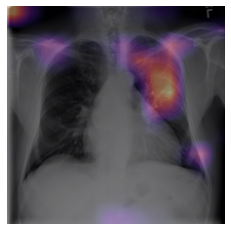

Patient age: 77, sex: M
Study description: Effusion
Probability of Pneumonia: 0.22254069
Predicted Pneumonia: True



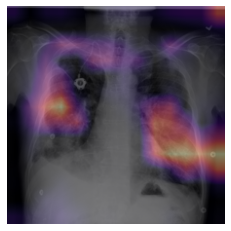

Body part not supported: RIBCAGE
This device only works with Chest Radiographies
Modality not supported: CT
This device only works with the DX modality (Digital Radiography)
Body position not supported: XX
This device only works with AP or PA positions


In [13]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json'
weight_path = 'xray_class_my_model.best.hdf5'

IMG_SIZE=(1, 224, 224, 3)

my_model = load_model(model_path, weight_path)
thresh = 0.13216244

# use the .dcm files to test your prediction
for i in test_dicoms:
    img = read_dicom(i)
    if img is None:
        continue
        
    img_proc = preprocess_image(img, IMG_SIZE)
    pred = predict_image(my_model, img_proc, thresh)

Patient age: 77, sex: M
Study description: Effusion
Probability of Pneumonia: 0.22254069
Predicted Pneumonia: True



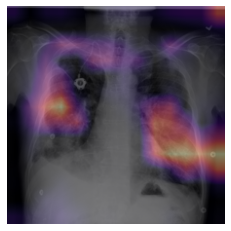

CPU times: user 3.29 s, sys: 71.1 ms, total: 3.36 s
Wall time: 3.34 s


In [14]:
%%time
# Time an image prediction
img = read_dicom('test3.dcm')
img_proc = preprocess_image(img, IMG_SIZE)
pred = predict_image(my_model,img_proc,thresh)

In [11]:
!pip install py-cpuinfo

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import cpuinfo
cpuinfo.get_cpu_info()

{'python_version': '3.7.6.final.0 (64 bit)',
 'cpuinfo_version': [9, 0, 0],
 'cpuinfo_version_string': '9.0.0',
 'arch': 'X86_64',
 'bits': 64,
 'count': 16,
 'arch_string_raw': 'x86_64',
 'vendor_id_raw': 'AuthenticAMD',
 'brand_raw': 'AMD EPYC 7B12',
 'hz_advertised_friendly': '2.2500 GHz',
 'hz_actual_friendly': '2.2500 GHz',
 'hz_advertised': [2249998000, 0],
 'hz_actual': [2249998000, 0],
 'model': 49,
 'family': 23,
 'flags': ['3dnowext',
  '3dnowprefetch',
  'abm',
  'adx',
  'aes',
  'apic',
  'arat',
  'avx',
  'avx2',
  'bmi1',
  'bmi2',
  'clflush',
  'clflushopt',
  'clwb',
  'clzero',
  'cmov',
  'cmp_legacy',
  'constant_tsc',
  'cpuid',
  'cr8_legacy',
  'cx16',
  'cx8',
  'de',
  'extd_apicid',
  'f16c',
  'fma',
  'fpu',
  'fsgsbase',
  'fxsr',
  'fxsr_opt',
  'ht',
  'hypervisor',
  'ibpb',
  'ibrs',
  'lahf_lm',
  'lm',
  'mca',
  'mce',
  'misalignsse',
  'mmx',
  'mmxext',
  'movbe',
  'msr',
  'mtrr',
  'nonstop_tsc',
  'nopl',
  'npt',
  'nrip_save',
  'nx',
  'o